In [20]:
# Luca Soltero
import pandas as pd
import sqlite3

repo_dir = "your path here"
conn = sqlite3.connect(repo_dir)
curs = conn.cursor()
pd.set_option('display.max_columns', None)

qry = """WITH prelim AS (
    SELECT
        dir.dealid,
        dir.investorfundid,
        dir.InvestorInvestmentAmount,
        dir.NumberOfSharesAcquired AS NumberOfSharesAcquired_DIR,
        d.NumberOfSharesAcquired AS NumberOfSharesAcquired_D,
        d.PercentAcquired,
        d.DealSize,
        d.SeriesOfStock,
        d.DealDate,
        d.CompanyID,
        d.DealID
    FROM
        DealInvestorRelation dir
    LEFT JOIN
        Deal d ON dir.dealid = d.DealID
),
joined AS (
    SELECT
        p.dealid,
        p.investorfundid,
        p.InvestorInvestmentAmount,
        p.NumberOfSharesAcquired_DIR,
        p.NumberOfSharesAcquired_D,
        p.PercentAcquired,
        p.DealSize,
        p.DealDate,
        p.CompanyID,
        p.DealID,
        f.FundCountry,
        CASE
            WHEN p.SeriesOfStock LIKE '%Seed%' THEN 'Seed'
            WHEN p.SeriesOfStock LIKE '%A%' THEN 'A'
            WHEN p.SeriesOfStock LIKE '%B%' THEN 'B'
            WHEN p.SeriesOfStock LIKE '%C%' THEN 'C'
            WHEN p.SeriesOfStock LIKE '%D%' THEN 'D'
            WHEN p.SeriesOfStock LIKE '%E%' THEN 'E'
            WHEN p.SeriesOfStock LIKE '%F%' THEN 'F'
            WHEN p.SeriesOfStock LIKE '%G%' THEN 'G'
            ELSE 'Null'
        END AS SeedType
    FROM
        prelim p
    LEFT JOIN
        Fund f ON p.investorfundid = f.fundid
),
seed_investment_info AS (
    SELECT
        *,
        CASE
            WHEN InvestorInvestmentAmount IS NOT NULL THEN 1
            ELSE 0
        END AS HasInvestedAmount
    FROM
        joined
),
ranked_investments AS (
    SELECT
        *,
        ROW_NUMBER() OVER (PARTITION BY investorfundid, CompanyID ORDER BY DealDate) AS Rank
    FROM
        seed_investment_info
),
company_info AS (
    SELECT
        ri.*,
        c.companyid,
        c.GrowthRate,
        c.HQCountry
    FROM
        ranked_investments ri
    JOIN
        Company c ON ri.CompanyID = c.companyid
)
SELECT
    ci.*
FROM
    company_info ci
WHERE
    ci.InvestorInvestmentAmount IS NOT NULL
    AND ci.FundCountry = 'United States';"""

# query sample of interest

df = pd.read_sql_query(qry, conn)
df['DealDate'] = pd.to_datetime(df['DealDate'])
df.rename(columns={'NumberOfSharesAcquired': 'NumberOfSharesAcquired_DIR'}, inplace=True)

In [21]:
# calculate fund pa and total shares
df["TotalShares"] = (df["NumberOfSharesAcquired_D"]/df["PercentAcquired"]) * 100
df["FundPA"] = (df["NumberOfSharesAcquired_DIR"]/df["TotalShares"]) * 100
df["PredictedFundPA_0"] = (df["InvestorInvestmentAmount"]/df["DealSize"]) * df["PercentAcquired"]

In [27]:
# drop values past 95%
percentile_95 = df["DealSize"].quantile(0.95)
distDF = df[df["DealSize"] <= percentile_95]
distribution = distDF["DealSize"].describe()
print(distribution)

count    25176.000000
mean         7.209635
std         11.586635
min          0.000015
25%          0.250000
50%          2.225000
75%          8.000001
max         60.499970
Name: DealSize, dtype: float64


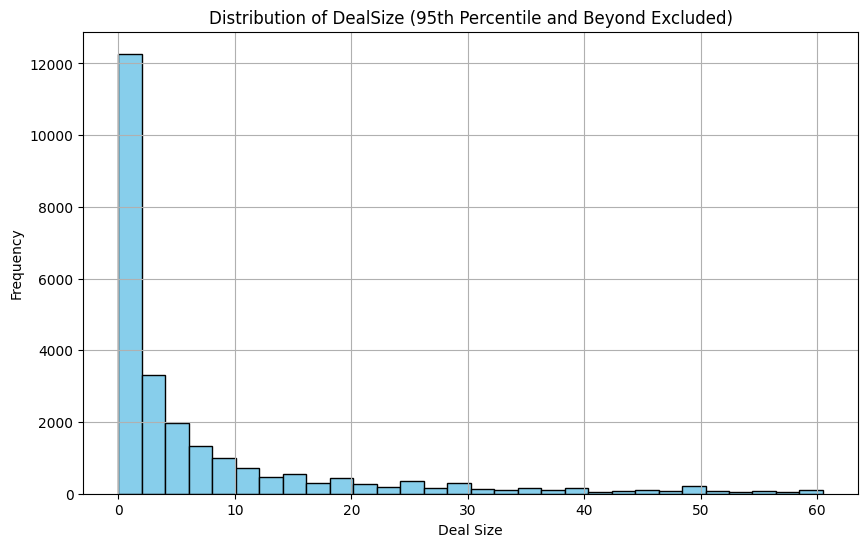

In [28]:
# graph distribution
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))
plt.hist(distDF["DealSize"], bins=30, color='skyblue', edgecolor='black')
plt.xlabel('Deal Size')
plt.ylabel('Frequency')
plt.title('Distribution of DealSize (95th Percentile and Beyond Excluded)')
plt.grid(True)
plt.show()

In [22]:
# calculate cumulative mean of deal size
cumulativeAverageDF = df.dropna(subset=["FundPA", "InvestorInvestmentAmount", "PercentAcquired"])
percentile_95 = cumulativeAverageDF["DealSize"].quantile(0.95)
cumulativeAverageDF = cumulativeAverageDF[cumulativeAverageDF["DealSize"] <= percentile_95]
print(cumulativeAverageDF["DealSize"].describe())
mean = cumulativeAverageDF["DealSize"].mean()

# calculate error from real value using deal size average in place of actual deal size
cumulativeAverageDF["PredictedAVG"] =  (cumulativeAverageDF["InvestorInvestmentAmount"]/mean) * cumulativeAverageDF["PercentAcquired"]
cumulativeAverageDF["AVG_error"] =  (cumulativeAverageDF["PredictedAVG"] - cumulativeAverageDF["FundPA"]).abs()
print("Distribution of Error using Cumulative Deal Size")
print(cumulativeAverageDF["AVG_error"].describe())



count    1481.000000
mean       30.636023
std        33.065374
min         0.017992
25%         5.500000
50%        20.000000
75%        41.349992
max       150.000001
Name: DealSize, dtype: float64
Distribution of Error using Cumulative Deal Size
count    1481.000000
mean        5.110252
std         7.747388
min         0.000272
25%         0.609343
50%         2.232985
75%         6.435258
max       114.242090
Name: AVG_error, dtype: float64


In [23]:
print(df["SeedType"].unique())

['Null' 'A' 'B' 'C' 'D' 'F' 'Seed' 'E' 'G']


In [24]:
# now we finetune for funding round. Iterate through seedtypes and get distribution of error from real values using this approach
seedList = ['Seed','A','B', 'C','D','E', 'F', 'G']
for seed in seedList:
    new = df[df["SeedType"] == seed]
    mean = new["DealSize"].mean()
    new = new.dropna(subset=["FundPA", "InvestorInvestmentAmount", "PercentAcquired"])
    new["PredictedAVG"] =  (new["InvestorInvestmentAmount"]/mean) * new["PercentAcquired"]
    new["AVG_error"] =  (new["PredictedAVG"] - new["FundPA"]).abs()
    print("Distribution of Error using Series ", seed, "Average")
    print(new["AVG_error"].describe())

Distribution of Error using Series  Seed Average
count    64.000000
mean      4.561862
std       6.349680
min       0.049532
25%       0.807084
50%       2.168676
75%       5.291251
max      30.387646
Name: AVG_error, dtype: float64
Distribution of Error using Series  A Average
count    403.000000
mean      13.788170
std       26.673149
min        0.010346
25%        0.942645
50%        3.503096
75%       13.412560
max      180.093098
Name: AVG_error, dtype: float64
Distribution of Error using Series  B Average
count    298.000000
mean       5.060982
std       18.638642
min        0.000544
25%        0.430597
50%        1.551027
75%        4.919556
max      307.890231
Name: AVG_error, dtype: float64
Distribution of Error using Series  C Average
count    190.000000
mean       3.171371
std        6.838116
min        0.003733
25%        0.401311
50%        1.171519
75%        3.226519
max       76.298670
Name: AVG_error, dtype: float64
Distribution of Error using Series  D Average
count  

In [ ]:
conn.close()